In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')
from lib import datadir
import lib

In [3]:
disprot = pd.read_csv(datadir+'disprot.tsv', sep='\t')
disprot.head()

,Type,DisProt entry ID,DisProt region ID,UniProt ACC,Protein name,Organism,Ncbi_taxon_id,Start,End,Term,EC,Reference,Confidence,Obsolete,Sequence
0,evidence,DP00003,DP00003r002,P03265,DNA-binding protein,Human adenovirus C serotype 5,28285,294.0,334.0,DO:00076,DO:00130,pmid:8632448,NaN,NaN,EHVIEMDVTSENGQRALKEQSSKAKIVKNRWGRNVVQISNT
1,evidence,DP00003,DP00003r003,P03265,DNA-binding protein,Human adenovirus C serotype 5,28285,294.0,334.0,DO:00002,DO:00130,pmid:8632448,NaN,NaN,EHVIEMDVTSENGQRALKEQSSKAKIVKNRWGRNVVQISNT
2,evidence,DP00003,DP00003r004,P03265,DNA-binding protein,Human adenovirus C serotype 5,28285,454.0,464.0,DO:00076,DO:00130,pmid:8632448,NaN,NaN,VYRNSRAQGGG
3,uniprot_sequence,NaN,NaN,P03265,DNA-binding protein,Human adenovirus C serotype 5,28285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASREEEQRETTPERGRGAARRPPTMEDVSSPSPSPPPPRAPPKKR...
4,consensus_full,DP00003,NaN,P03265,DNA-binding protein,Human adenovirus C serotype 5,28285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,----------------------------------------------...


In [4]:
disordered_protein_accs = disprot[disprot['Ncbi_taxon_id']==9606][' UniProt ACC'].unique()
disordered_protein_accs.shape

(525,)

In [5]:
disordered_regions = disprot[(disprot['Ncbi_taxon_id']==9606) & (disprot['Type']=='evidence')]['Sequence'].unique()
disordered_regions.shape

(881,)

In [6]:
proteome = lib.load_proteome_as_df('Human')

In [7]:
mask = proteome['Accession'].isin(disordered_protein_accs)
dfs = []
for m in [~mask, mask]:
    dfs.append(lib.Counter(proteome[m]['Sequence'], 1).to_df())
dfs.append(lib.Counter(disordered_regions, 1).to_df())

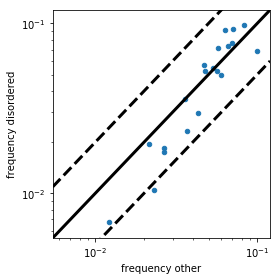

In [8]:
dfmerged = pd.merge(dfs[0], dfs[2], on='seq', suffixes=['_rest', '_disordered'])
dfmerged.set_index('seq', inplace=True)

fig, ax = plt.subplots(figsize=(4, 4))
xmin, xmax = 0.8*np.amin(dfmerged['freq_disordered']), 1.2*np.amax(dfmerged['freq_rest'])
x = np.logspace(np.log10(xmin), np.log10(xmax))
ax.plot(x, x, 'k', lw=3)
ax.plot(x, x*2, '--k', lw=3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.plot(x, x/2, '--k', lw=3)
dfmerged.plot(x='freq_rest', y='freq_disordered', kind='scatter', logx=True, logy=True, ax=ax);
ax.set_xlabel('frequency other')
ax.set_ylabel('frequency disordered')
fig.tight_layout()

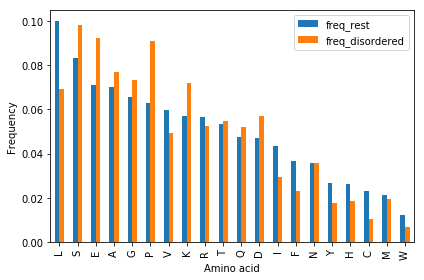

In [9]:
fig, ax = plt.subplots()
dfmerged.sort_values(by='freq_rest', inplace=True, ascending=False)
dfmerged.plot(kind='bar', ax=ax)
ax.set_xlabel('Amino acid')
ax.set_ylabel('Frequency')
fig.tight_layout()


Text(0, 0.5, 'Enrichment')

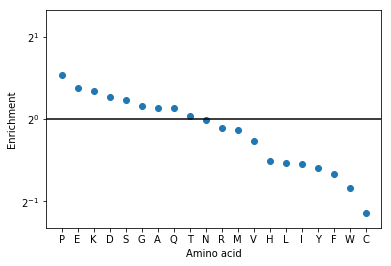

In [10]:
oddsratio = dfmerged['freq_disordered']/dfmerged['freq_rest']
oddsratio.sort_values(inplace=True, ascending=False)
fig, ax = plt.subplots()
ax.plot(oddsratio, 'o')
ax.set_yscale('log', basey=2)
ax.axhline(1.0, c='k')
ax.set_ylim(1/2.5, 2.5)
ax.set_xlabel('Amino acid')
ax.set_ylabel('Enrichment')

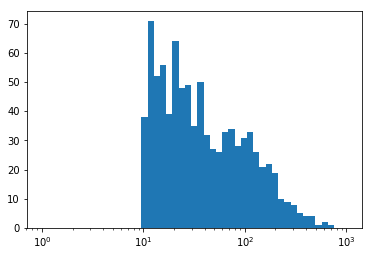

In [11]:
disordered_regions_length = [len(s) for s in disordered_regions]
plt.hist(disordered_regions_length, bins=np.logspace(0, 3))
plt.xscale('log')

In [12]:
def enrichment(gap):
    df1 = lib.Counter(disordered_regions, 1, gap).to_df(norm=True)
    df1.set_index('seq', inplace=True)
    df2 = lib.Counter(disordered_regions, 2, gap).to_df(norm=True)
    lib.strcolumn_to_charcolumns(df2, 'seq')
    df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]) for s in df2['seq']]
    df2['fold'] = np.log2(df2['freq']/df2['theory'])
    dfmat = df2.pivot(columns='aa1', index='aa2')['fold']
    return dfmat

AxesSubplot(0.547727,0.125;0.352273x0.343182)


/home/amayer/.conda/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


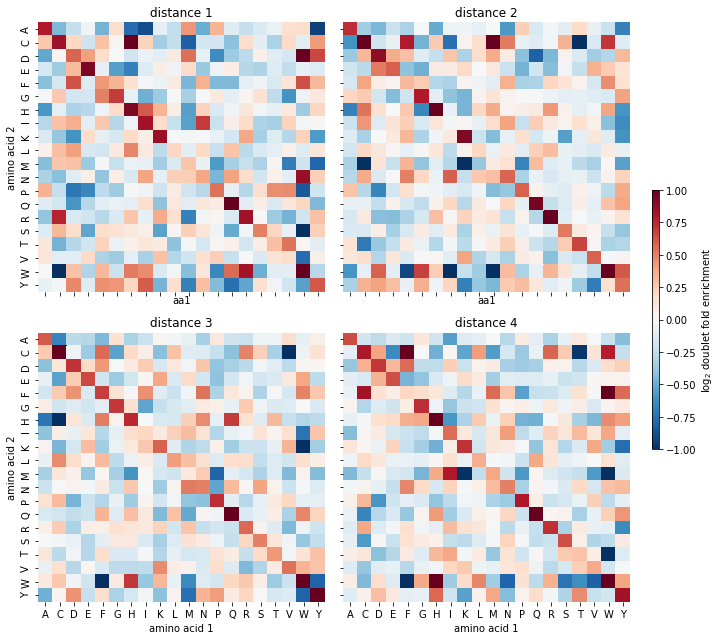

In [13]:
fig, axes = plt.subplots(figsize=(10.0, 9), nrows=2, ncols=2,
        sharex=True, sharey=True)
for gap, ax in zip(range(len(axes.flatten())), axes.flatten()):
    df = enrichment(gap)
    ax.set_title('distance '+str(gap+1))
    im = sns.heatmap(df, ax=ax, cbar=False,
            vmin=-1.0, vmax=1.0, cmap='RdBu_r')
print(im)
cax = fig.add_axes((0.91, 0.3, 0.01, 0.4))
fig.colorbar(im.collections[0], cax=cax, label='log$_2$ doublet fold enrichment')
for ax in axes[1, :]:
    ax.set_xlabel('amino acid 1')
for ax in axes[:, 0]:
    ax.set_ylabel('amino acid 2')
for ax in axes[:, 1]:
    ax.set_ylabel('')
fig.tight_layout(rect=[0, 0, 0.9, 1.0])

In [13]:
df2 = lib.Counter(disordered_regions, 2, gap).to_df(norm=True)
df2

,seq,freq
226,AA,0.009542
319,AC,0.000756
8,AD,0.003387
133,AE,0.006671
222,AF,0.001719
28,AG,0.005777
209,AH,0.001358
270,AI,0.001702
19,AK,0.006103
186,AL,0.005158


In [43]:
gaps = np.arange(0, 50)
mis = []
mistds = []
mi_shuffleds = []
for gap in gaps:
    mi, mi_std = lib.calc_mi_std(list(disordered_regions), gap)
    mi_shuffled = lib.calc_mi(lib.scrambled(list(disordered_regions)), gap)
    mis.append(mi)
    mistds.append(mi_std)
    mi_shuffleds.append(mi_shuffled)

In [17]:
uniquedomains = pd.read_csv('../pfam/data/mutualinformation_uniquedomains.csv', index_col=0)
humanall = pd.read_csv('../mivsdist/data/mutualinformation-Human.csv', index_col=0)

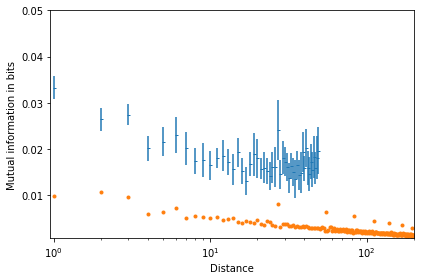

In [45]:
fig, ax = plt.subplots()
err = ax.errorbar(gaps, mis, np.array(mistds), fmt='_', ms=3)
#ax.plot(gaps, mi_shuffleds, 'o', ms=3)
ax.errorbar(np.array(humanall['gaps']), np.array(humanall['mutualinformation']),
            np.array(humanall['mutualinformation_std']), fmt='o', ms=3)
#d = np.arange(1, 200)
#l, = ax.plot(d, 0.018*d**-.5, zorder=10, c='k', label=r'power law ($-1/2$)')

#ax.legend(loc='upper right', ncol=2)
ax.set_ylim(0.0008, 0.05)
ax.set_xlim(0.95, 201.0)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Distance')
ax.set_ylabel('Mutual information in bits')
fig.tight_layout()
